In [1]:
from pynq import Overlay
from pynq import allocate
import xrfclk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ol = Overlay("hw/top.bit", download=True)

In [3]:
ol?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff656f8220>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay hw/top.bit. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma_0            : pynq.lib.dma.DMA
axi_gpio_capture     : pynq.lib.axigpio.AxiGPIO
axi_gpio_pinc        : pynq.lib.axigpio.AxiGPIO
axi_gpio_scale       : pynq.lib.axigpio.AxiGPIO
rf_data_converter    : pynq.overlay.DefaultIP
zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP

Hierarchies
-----------
dds_wrapper_0        : pynq.overlay.DefaultHierarchy
sample_buffer_wrapper_0 : pynq.overlay.DefaultHierarchy

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time


In [4]:
dma_recv = ol.axi_dma_0.recvchannel
capture_trig = ol.axi_gpio_capture.channel1[0]
pinc = ol.axi_gpio_pinc.channel1
cos_scale = ol.axi_gpio_scale.channel1
xrfclk.set_ref_clks(lmk_freq=122.88, lmx_freq=409.6)

In [14]:
pinc.write(3178,0xffffff)
cos_scale.write(2, 0xf)

In [82]:
frame_size = 32768*4
buffer = allocate(shape=(frame_size,), dtype=np.uint64)
ol.axi_gpio_capture.channel1[0].on()
dma_recv.transfer(buffer)
ol.axi_gpio_capture.channel1[0].off()
for i in range(10):
    print('0x' + format(buffer[i], '02x'))

0xe8c3e8c3e8f4e926
0xe82fe82fe860e860
0xe79be79be7cce7fd
0xe707e738e738e738
0xe673e673e6a4e6d5
0xe5aee5dfe610e642
0xe51ae54ce54ce57d
0xe456e487e4b8e4e9
0xe3f4e425e425e456
0xe361e361e392e3c3


In [81]:
ol.axi_gpio_pinc.channel1.write(3178, 0xffffff)

In [87]:
flattened = np.zeros(shape=(frame_size*4,))
for i in range(frame_size):
    for j in range(4):
        val = (int(buffer[i]) >> (16*j)) & 0xffff
        if (val & 0x8000):
            val -= 0x10000
        flattened[4*i+j] = val

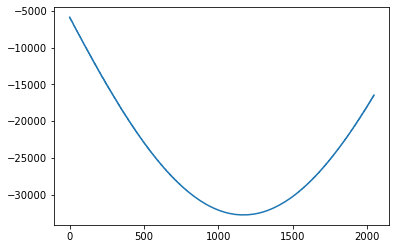

In [88]:
plt.plot(flattened[:2048])

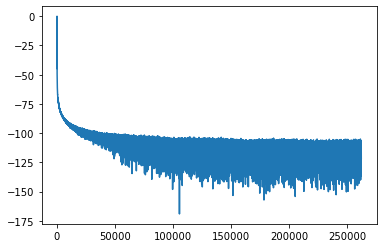

In [89]:
fft = 20*np.log10(abs(np.fft.rfft(flattened)))
fft -= np.max(fft)
plt.plot(fft)

In [67]:
np.random.randint(dtype=np.uint128)

AttributeError: module 'numpy' has no attribute 'uint128'

In [68]:
np.sctypes

{'int': [numpy.int8, numpy.int16, numpy.int32, numpy.int64],
 'uint': [numpy.uint8, numpy.uint16, numpy.uint32, numpy.uint64],
 'float': [numpy.float16, numpy.float32, numpy.float64, numpy.float128],
 'complex': [numpy.complex64, numpy.complex128, numpy.complex256],
 'others': [bool, object, bytes, str, numpy.void]}